# 4. Stitch outputs together
- Once you have fitted the weak, medium and dense diads, stitch them all together, and apply the Ne correction model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import DiadFit as pf
pf.__version__

'0.0.77'

In [2]:
# Load in settings, paths, file extensions etc. that you saved in step 1
meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower=pf.get_settings()

## Load in specra, and combine

In [3]:
import os
df2=pf.merge_fit_files(path=os.getcwd())

## First, get the metadata for this day

In [4]:
# Put the common string you can in all your Ne lines here
diad_meta=pf.get_files(path=meta_path,
file_ext=file_ext, exclude_str=['Ne', 'FG', 'Cap','window'],
 sort=True)
diad_meta[0]

'02 K23_10_FIA_50X.txt'

## Now get all the important information out of the metadata files

In [5]:
# This will only work for WITEC - for other vendors, you might have to use the file datastamp. See the HORIBA example
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=diad_meta, prefix=prefix, str_prefix=prefix_str,
trupower=TruPower)
meta.head()

100%|██████████| 39/39 [00:00<00:00, 1651.92it/s]

Done


,filename,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,K23_10_FIA_50X.txt,"September 20, 2023\n",September,20.0,12.044,60.0,4.0,50.0,"['0h', '4m', '2s']",2:25:32 PM\n,51932.0,1325.004
1,Spectrum--009--Information.txt,"September 20, 2023\n",September,20.0,12.056,60.0,4.0,50.0,"['0h', '0m', '1s']",2:30:09 PM\n,52209.0,1325.004
2,K23_1_FIA_50X.txt,"September 20, 2023\n",September,20.0,12.185,45.0,3.0,50.0,"['0h', '2m', '16s']",2:33:31 PM\n,52411.0,1325.004
3,K23_1_FIA_50X_r2_longeraq.txt,"September 20, 2023\n",September,20.0,12.237,60.0,4.0,50.0,"['0h', '4m', '2s']",2:36:33 PM\n,52593.0,1325.004
4,K23_2_FIA_50X.txt,"September 20, 2023\n",September,20.0,11.964,60.0,4.0,50.0,"['0h', '4m', '2s']",2:52:03 PM\n,53523.0,1325.004


## Then get a simple file name you can stitch with the spectra

In [6]:
file_m=pf.extracting_filenames_generic(names=meta['filename'],
   file_ext=file_ext)
# Checks they are all unique
file_m[0]

good job, no duplicate file names


'K23_10_FIA_50X'

## Now get filename from spectra into same form as metadata

In [7]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(
    names=df2['filename'].reset_index(drop=True),
   file_ext=file_ext)

# Remove the cosmic rays, as doesnt have it in the metatdata
file_s = np.char.replace(file_s.astype(str), "_CRR_DiadFit", "")
print(file_s[0])

good job, no duplicate file names
K23_10_FIA_50X


In [8]:
# Combining them together, if the form above matches, e.g. checking one doesnt have a suffix and the other one does

meta['filename']=file_m
df2['filename']=file_s
df_combo=pd.merge(df2, meta, on='filename').reset_index(drop=True)
df_combo.head()

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,K23_10_FIA_50X,103.321211,0.003304,1285.530242,0.003003,1362.541566,1285.530292,2153.795453,0.586062,5.329910,...,September,20.0,12.044,60.0,4.0,50.0,"['0h', '4m', '2s']",2:25:32 PM\n,51932.0,1325.004
1,K23_1_FIA_50X,103.356742,0.002075,1285.483705,0.001819,1291.098383,1285.483755,2046.897655,0.591294,3.329590,...,September,20.0,12.185,45.0,3.0,50.0,"['0h', '2m', '16s']",2:33:31 PM\n,52411.0,1325.004
2,K23_1_FIA_50X_r2_longeraq,103.347836,0.001650,1285.494697,0.001417,1852.376087,1285.494747,2949.331252,0.593544,3.896763,...,September,20.0,12.237,60.0,4.0,50.0,"['0h', '4m', '2s']",2:36:33 PM\n,52593.0,1325.004
3,K23_2_FIA_50X,103.002850,0.032459,1286.359590,0.029483,46.321659,1286.359590,45.981107,0.466575,1.842057,...,September,20.0,11.964,60.0,4.0,50.0,"['0h', '4m', '2s']",2:52:03 PM\n,53523.0,1325.004
4,K23_2_FIB_50X,103.154303,0.003341,1285.991130,0.002903,628.365155,1285.991180,763.817925,0.484207,2.727443,...,September,20.0,11.935,60.0,4.0,50.0,"['0h', '4m', '1s']",2:56:49 PM\n,53809.0,1325.004


## If you have secondary phases, now is the time to merge those in

In [19]:
df_combo_sec_phase=pf.merge_in_carb_SO2(
df_combo=df_combo, file1_name='Carb_Peak_fits.xlsx', file2_name='SO2_Peak_fits.xlsx', 
prefix=prefix, str_prefix=prefix_str, file_ext=file_ext)
#df_combo_sec_phase.to_excel('FI_fitting_w_sec_phases.xlsx', index=False)

Made a df!
good job, no duplicate file names


## If you have SO2, now is the time to calculate the molar proportion of SO2

In [1]:
if 'Peak_Area_SO2' in df_combo_sec_phase:
    SO2_ratio=pf.calculate_CO2_SO2_ratio(peak_area_SO2=df_combo_sec_phase['Peak_Area_SO2'], 
peak_area_diad1=df_combo_sec_phase['Diad1_Voigt_Area'], peak_area_diad2=df_combo_sec_phase['Diad2_Voigt_Area'],
wavelength=532.067, T_K=37+273.15,efficiency_SO2=1, efficiency_CO2=0.5, 
sigma_SO2=4.03, sigma_CO2_v1=0.8, sigma_CO2_v2=1.23)
df_combo_sec_phase['SO2_mol_ratio']=SO2_ratio['SO2']

NameError: name 'df_combo_sec_phase' is not defined

## Now we calculate the density using the UC Berkeley Densimeter. 
- If you have your own densimeter, I am happy to add a function for it if you email me (penny_wieser@berkeley.edu)
- This particular function propagates the uncertainty on 1) The neon line correction model 2) the peak fits of the diads themselves 3) The densimeter. 

In [27]:
df=pf.calculate_density_ucb(df_combo=df_combo_sec_phase,
  Ne_pickle_str='Neon_corr_model.pkl',  temp='SupCrit', CI_split=0.67, CI_neon=0.67)
df.head()

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,SO2_mol_ratio,time,preferred_values,lower_values,upper_values
0,K23_10_FIA_50X,0.131039,0.004066,0.001310,0.003849,103.080962,0.003307,0.000262,0.003304,12.044,...,NaN,NaN,NaN,NaN,0.102513,2.4,51932.0,0.997675,0.997672,0.997677
1,K23_1_FIA_50X,0.144743,0.003971,0.000827,0.003884,103.115547,0.002087,0.000259,0.002075,12.185,...,NaN,NaN,NaN,NaN,NaN,NaN,52411.0,0.997666,0.997664,0.997669
2,K23_1_FIA_50X_r2_longeraq,0.141096,0.003930,0.000660,0.003874,103.106342,0.001666,0.000258,0.001650,12.237,...,NaN,NaN,NaN,NaN,NaN,NaN,52593.0,0.997663,0.997661,0.997666
3,K23_2_FIA_50X,0.004106,0.000000,0.000000,0.000000,102.760619,0.032383,0.000252,0.032459,11.964,...,NaN,NaN,NaN,NaN,0.371778,8.2,53523.0,0.997648,0.997646,0.997651
4,K23_2_FIB_50X,0.063799,0.004039,0.001325,0.003816,102.911267,0.003343,0.000251,0.003341,11.935,...,NaN,NaN,NaN,NaN,0.092151,2.2,53809.0,0.997644,0.997642,0.997646


### This cell saves the merged together dataframe with the folder name and the date you fitted it

In [29]:

from datetime import date
today = date.today()
today_str = today.strftime("%Y-%m-%d")
sorted_df = df.sort_values('sec since midnight')
date=meta['date'].iloc[0].replace('\n', '')
name='Raman_session_'+date+'_fitted_'+today_str+'.xlsx'
print(name)
sorted_df.to_excel(name)

Raman_session_September 20, 2023_fitted_2023-10-05.xlsx


## This helps visualize the errors on each spectra 

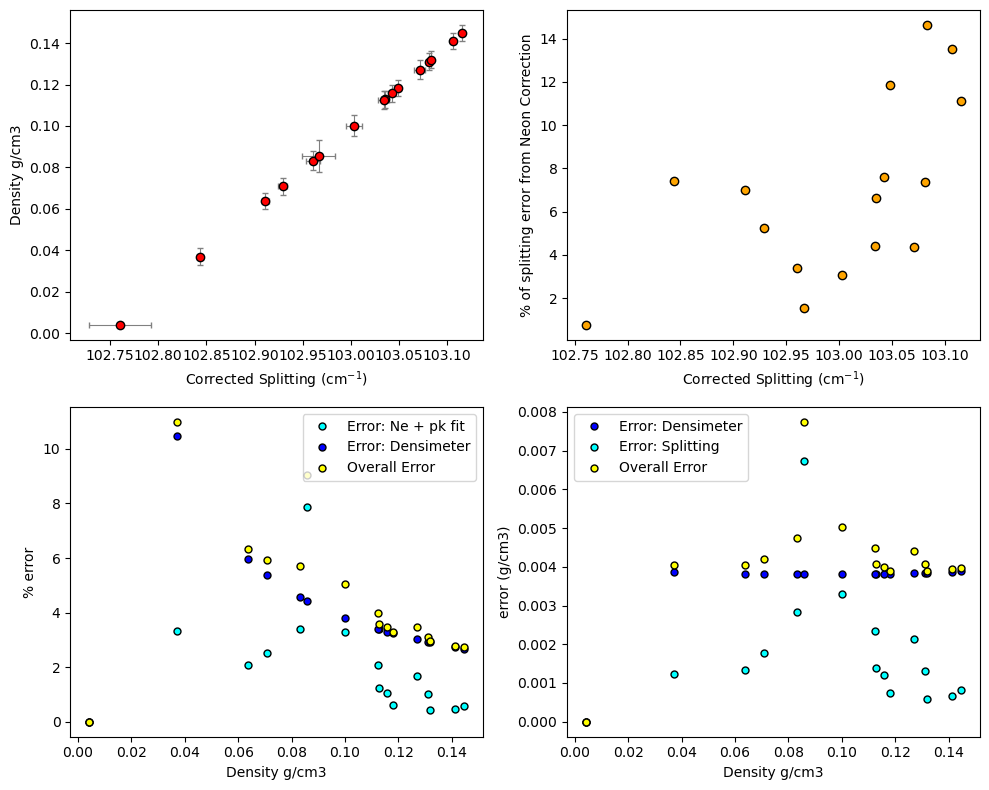

In [30]:
df=sorted_df
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
df=df.loc[df['Density g/cm3']>0]
ax1.errorbar(df['Corrected_Splitting'], df['Density g/cm3'],
xerr=df['Corrected_Splitting_σ'], yerr=df['σ Density g/cm3'],
fmt='o', ecolor='grey', elinewidth=0.8, mfc='red', ms=6, mec='k', capsize=2)
ax1.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax1.set_ylabel('Density g/cm3')

ax2.plot(df['Corrected_Splitting'], 
100*df['Corrected_Splitting_σ_Ne']/(df['Corrected_Splitting_σ_Ne']+df['Corrected_Splitting_σ_peak_fit']),
 'ok', mfc='orange')
ax2.set_ylabel('% of splitting error from Neon Correction')
ax2.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from Ne+peakfit)']/df['Density g/cm3'], 
'ok', mfc='cyan', ms=5, label='Error: Ne + pk fit')


ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from densimeter)']/df['Density g/cm3'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')

ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3']/df['Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax3.set_ylabel('% error')
ax3.set_xlabel('Density g/cm3')
ax3.legend()

ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from densimeter)'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from Ne+peakfit)'], 
'ok', mfc='cyan', ms=5, label='Error: Splitting')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax4.set_ylabel('error (g/cm3)')
ax4.set_xlabel('Density g/cm3')
ax4.legend()

fig.tight_layout()

## If you were analysing fluid inclusions, lets calculate their pressures
- This bit isn't valid for melt inclusion vapour bubbles. 

Text(0, 0.5, '# of FI')

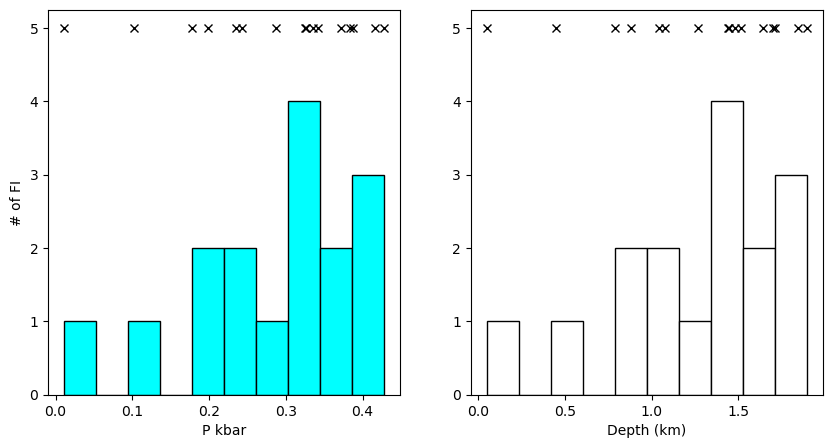

In [37]:
# Calculate pressure with a temperature estimate
Temp_C=1150
Pressure_SW96=pf.calculate_P_for_rho_T(T_K=Temp_C+273.15,
                CO2_dens_gcm3=df['Density g/cm3'],
                 EOS='SP94')
# Calculate depth from a crustal density assumption
Depth=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'], 
                crust_dens_kgm3=2300)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(Pressure_SW96['P_kbar'], ec='k', fc='cyan', bins=10)
ax1.plot(Pressure_SW96['P_kbar'], Pressure_SW96['P_kbar']*0+5, 'xk')
ax2.plot(Depth, Pressure_SW96['P_kbar']*0+5, 'xk')
ax2.hist(Depth, ec='k', fc='white', bins=10)
ax1.set_xlabel('P kbar')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('# of FI')